In [17]:
import random
import shutil
from pathlib import Path

import matplotlib.pyplot as plt
from matplotlib.image import imread
from tensorflow.keras import backend as K
from tensorflow.keras.layers import (
    Activation,
    Conv2D,
    Dense,
    Dropout,
    Flatten,
    MaxPooling2D,
)
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [18]:
# Define the temporary directory relative to the current notebook
temp_dir = Path("./tmp/PetImages")
temp_dir.mkdir(parents=True, exist_ok=True)  # Create the directory if it doesn't exist

# Download and extract the dataset
local_zip = temp_dir / "cats-and-dogs.zip"
!wget --no-check-certificate \
    "https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip" \
    -O {local_zip}

# Extract the zip file into the temp directory
with zipfile.ZipFile(local_zip, "r") as zip_ref:
    zip_ref.extractall(temp_dir)

# Verify extraction
print(f"Files extracted to {temp_dir.resolve()}")

# Define BDIR and create necessary directories
BDIR = temp_dir / "dataSmall"
train_data_dir = BDIR / "train"
validation_data_dir = BDIR / "validation"

for directory in [train_data_dir, validation_data_dir]:
    for category in ["Cat", "Dog"]:
        (directory / category).mkdir(parents=True, exist_ok=True)

# Number of samples
nb_train_samples = 400
nb_validation_samples = 200


# Function to split and distribute files
def split_data(src_dir, train_dest, val_dest, train_size, val_size):
    files = [f for f in src_dir.iterdir() if f.is_file()]
    random.shuffle(files)  # Shuffle files for random distribution
    for f in files[:train_size]:
        shutil.copy(f, train_dest / f.name)
    for f in files[train_size : train_size + val_size]:
        shutil.copy(f, val_dest / f.name)


# Split data for Cat and Dog categories
original_cat_dir = temp_dir / "PetImages" / "Cat"
original_dog_dir = temp_dir / "PetImages" / "Dog"

split_data(
    original_cat_dir,
    train_data_dir / "Cat",
    validation_data_dir / "Cat",
    nb_train_samples // 2,
    nb_validation_samples // 2,
)
split_data(
    original_dog_dir,
    train_data_dir / "Dog",
    validation_data_dir / "Dog",
    nb_train_samples // 2,
    nb_validation_samples // 2,
)

# Verify directory structure
print(f"Train data directory: {train_data_dir}")
print(f"Validation data directory: {validation_data_dir}")

# Hyperparameters
img_width, img_height = 150, 150
epochs = 50
batch_size = 16

# Set input shape
if K.image_data_format() == "channels_first":
    input_shape = (3, img_width, img_height)
else:
    input_shape = (img_width, img_height, 3)


--2025-01-10 16:04:46--  https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip
Resolving download.microsoft.com (download.microsoft.com)... 2a02:26f0:dc:389::317f, 2a02:26f0:dc:38d::317f, 2.22.113.177
Connecting to download.microsoft.com (download.microsoft.com)|2a02:26f0:dc:389::317f|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 824887076 (787M) [application/octet-stream]
Saving to: ‘temp/PetImages/cats-and-dogs.zip’

temp/PetImages/cats 100%[===================>] 786.67M  19.1MB/s    in 33s     

2025-01-10 16:05:19 (23.7 MB/s) - ‘temp/PetImages/cats-and-dogs.zip’ saved [824887076/824887076]

Files extracted to /home/nissim/Documents/dev/musa-650-spring-2025/week07/temp/PetImages
Train data directory: temp/PetImages/dataSmall/train
Validation data directory: temp/PetImages/dataSmall/validation


In [63]:
def plot(data_generator):
    """
    Plots 6 images generated by an object of the ImageDataGenerator class.
    """
    # Create an iterator from the single image dataset
    image_iterator = data_generator.flow(images, batch_size=1)

    # Plot the augmented images
    fig, axes = plt.subplots(nrows=1, ncols=6, figsize=(18, 18))
    for ax in axes:
        batch = next(image_iterator)  # Generate the next augmented image
        ax.imshow(batch[0].astype("int"))  # Cast to int for display
        ax.axis("off")
    plt.show()

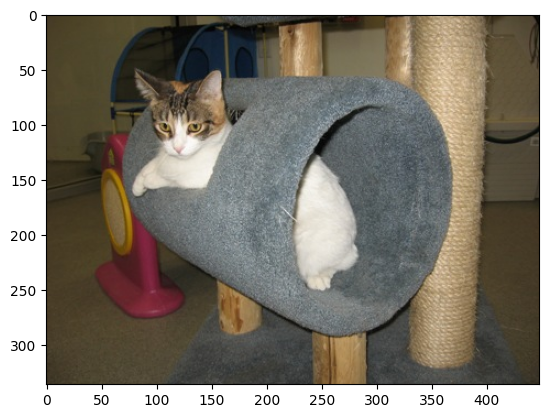

In [64]:
# note that you may have to adjust this path based on how images have been randomly saved to your local directory
image_path = train_data_dir / "Cat/90.jpg"
image = imread(image_path)

# Creating a dataset which contains just one image.
images = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))

imshow(images[0])
show()

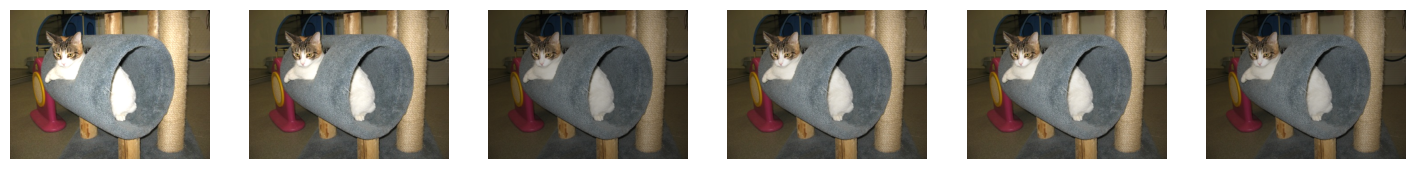

In [65]:
# Create an ImageDataGenerator with augmentation
data_generator = ImageDataGenerator(brightness_range=(0.7, 1.3))

# Plot augmented images
plot(data_generator)

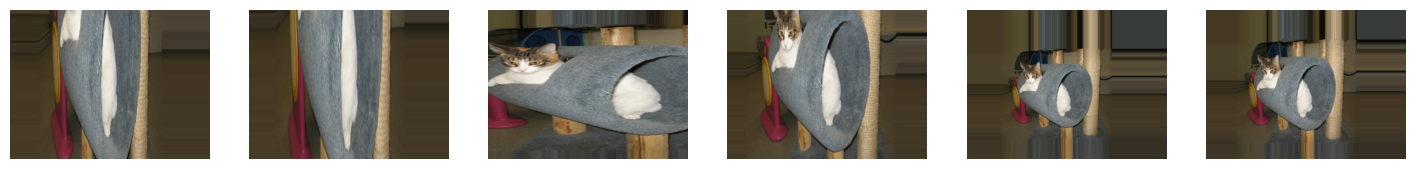

In [66]:
data_generator = ImageDataGenerator(zoom_range=[0.2, 2.5])
plot(data_generator)

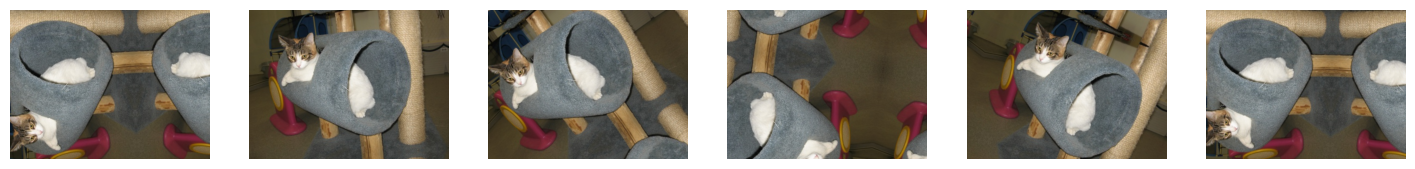

In [67]:
data_generator = ImageDataGenerator(rotation_range=180, fill_mode="reflect")
# data_generator = ImageDataGenerator(rotation_range=30)
# data_generator = ImageDataGenerator(rotation_range=180)
plot(data_generator)

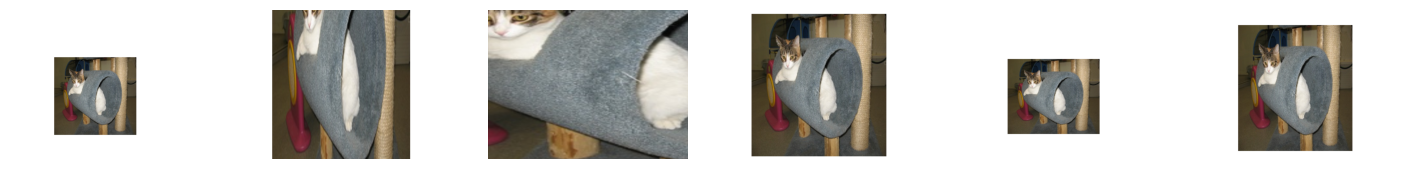

In [68]:
data_generator = ImageDataGenerator(
    zoom_range=[0.2, 2.5], fill_mode="constant", cval=255
)
# data_generator = ImageDataGenerator(zoom_range=[0.2, 2.5], fill_mode='wrap')
plot(data_generator)

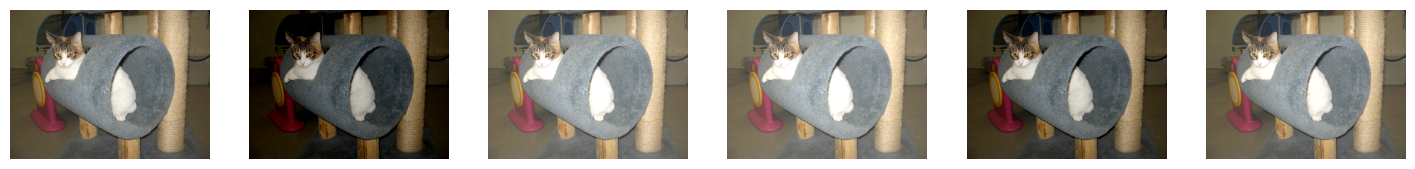

In [69]:
data_generator = ImageDataGenerator(channel_shift_range=50.0)
plot(data_generator)

In [70]:
# this is the augmentation configuration we will use for training
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255, shear_range=0.2, zoom_range=0.2, horizontal_flip=True
)

# this is the augmentation configuration we will use for testing:
# only rescaling
validation_datagen = ImageDataGenerator(rescale=1.0 / 255)

# Define generators
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode="binary",
)

validation_generator = validation_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode="binary",
)

Found 400 images belonging to 2 classes.
Found 200 images belonging to 2 classes.


In [ ]:
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=input_shape))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(64))
model.add(Activation("relu"))
model.add(Dropout(0.5))
model.add(Dense(1))
model.add(Activation("sigmoid"))

model.compile(loss="binary_crossentropy", optimizer="rmsprop", metrics=["accuracy"])

model.fit(
    train_generator,
    steps_per_epoch=nb_train_samples // batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=nb_validation_samples // batch_size,
)

Epoch 1/50


/home/nissim/snap/code/179/.local/share/virtualenvs/musa-650-spring-2025-BY6WbUPk/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/nissim/snap/code/179/.local/share/virtualenvs/musa-650-spring-2025-BY6WbUPk/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 70ms/step - accuracy: 0.4750 - loss: 0.8535 - val_accuracy: 0.4948 - val_loss: 0.6921
Epoch 2/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step - accuracy: 0.5536 - loss: 0.7205 - val_accuracy: 0.4844 - val_loss: 0.6926
Epoch 3/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step - accuracy: 0.4874 - loss: 0.6975 - val_accuracy: 0.5260 - val_loss: 0.6912
Epoch 4/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step - accuracy: 0.5377 - loss: 0.6945 - val_accuracy: 0.5677 - val_loss: 0.6858
Epoch 5/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 65ms/step - accuracy: 0.6586 - loss: 0.6835 - val_accuracy: 0.4896 - val_loss: 0.6927
Epoch 6/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 65ms/step - accuracy: 0.5380 - loss: 0.6853 - val_accuracy: 0.5781 - val_loss: 0.6847
Epoch 7/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 63ms/step - accuracy: 0.6230 - loss: 0.6749 - val_accuracy: 0.5781 - val_loss: 0.6732
Epoch 8/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - accuracy: 0.6434 - loss: 0.6625 - val_accuracy: 0.5885 - val_loss: 0.